In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)

In [4]:
batch_size = 8                      # b, b_sz
context_len = 1024                  # seq_len, context_length, num_tokens, t, n_tokens
d_model = 768                       # embed_dim, d_in, d_out, d
n_heads = 6                         # h
n_groups = 2                        # g
head_dim = d_model // n_heads       # d_k, d_v

In [5]:
x = torch.randn((batch_size, context_len, d_model), device=device)

# Többfejű Figyelem (Multi-Head Attention, MHA)

Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need.” arXiv, 2017. https://doi.org/10.48550/arXiv.1706.03762.

A figyelem mechanizmus lehetővé teszi a modell számára, hogy a rejtett állapotokból (hidden state) álló szekvencia minden pozíciója kölcsönhatásba lépjen ugyanabban a szekvenciában lévő többi pozícióval, ezáltal az egyes szekvenciákon belül képes megragadni a távolsági (és közeli) kontextust is.

Legyen $d$ beágyazás dimenzió és $\mathbf{h}_t \in \mathbb{R}^d$ a bemeneti szekvencia $t$-edik elemének beágyazása egy figyelem rétegnél. A figyelem mechanizmus a bemenetet először három eltérő súlyvektor segítségével három különböző reprezentációra, ún. lekérdezés-, kulcs- és értékvektorokra képezi le, de a gyakorlatban a számításokat mátrixokba rendezik a hatékonyság érdekében. A $\mathbf{W}^Q, \mathbf{W}^K \in \mathbb{R}^{d \times d_k}$, $\mathbf{W}^V \in \mathbb{R}^{d \times d_v}$ súlymátrixok állítják elő a $\mathbf{q}_t, \mathbf{k}_t \in \mathbb{R}^{d_k}$ és $\mathbf{v}_t \in \mathbb{R}^{d_v}$ reprezentációkat:

$$
\begin{aligned}
& \mathbf{q}_t=\mathbf{W}^Q \mathbf{h}_t, \\
& \mathbf{k}_t=\mathbf{W}^K \mathbf{h}_t, \\
& \mathbf{v}_t=\mathbf{W}^V \mathbf{h}_t,
\end{aligned}
$$

A $\mathbf{q}$ lekérdezés, ahonnan a figyelem irányul, mint a cél a figyelem mechanizmusban. A $\mathbf{k}$ kulcs, amire a figyelem irányul, mint a forrás az egyszerű figyelem mechanizmus esetén. A $\mathbf{v}$ érték az éppen generált kontextus. A képletben szereplő $q,k, v$ betűk az angol query, key, value szavak kezdőbetűi.

Következőnek, a lekérdezés- és kulcs skalárszorzatát veszik és elosztják a $\sqrt{d_k}$ skálázási faktorral a numerikus stabilitás érdekében. Ezután, softmax függvényt alkalmazva a figyelem súlyokat kapják meg, amik az értékkel kerülnek súlyozásra. Ezáltal a $t$-edik token reprezentációjának (vagy kódolt kimenetének) eredménye kiszámítható a figyelem mechanizmus alkalmazásával az alábbi módon:

$$
\mathbf{o}_{t}= \operatorname{softmax} \left( \frac{\mathbf{q}_{t} \mathbf{k}_{t}^T}{\sqrt{d_k}}\right) \mathbf{v}_{t}
$$

A szekvencia tokenjeinek kódolt kimenetei egyszerre számíthatók, mivel a fenti egyenletek kifejezhetőek olyan mátrixműveletekkel, amelyek hatékony módon számíthatóak párhuzamos számításokra specializált, modern hardvereken. A fenti egyenletet \textbf{skálázott skalárszorzat-alapú figyelem}nek (scaled dot-product attention) nevezzük.

Megjegyzés. A $d$, $d_k$ és $d_v$ gyakran megegyezik.

In [6]:
class Head(nn.Module):
    def __init__(self, d_model: int, d_out: int, attn_dropout: float = 0.1, qkv_bias: bool = False) -> None:
        super().__init__()

        self.key = nn.Linear(d_model, d_out, bias = qkv_bias)
        self.query = nn.Linear(d_model, d_out, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_out, bias = qkv_bias)

        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, attn_mask = None, padding_mask = None) -> torch.Tensor:

        b, t, d_model = query.shape

        q = self.query(query)   # (b, t, d_k)
        k = self.key(key)       # (b, t, d_k)
        v = self.value(value)   # (b, t, d_v)

        # (b, t, t) = (b, t, d) @ (b, d, t)
        attn_scores = q @ k.transpose(1, 2)

        # figyelem és padding maszk összefűzése
        if padding_mask is not None:
            padding_mask = padding_mask.view(b, 1, t)
            if attn_mask is None:
                attn_mask = padding_mask
            else:
                attn_mask = attn_mask + padding_mask # := logikai és

        if attn_mask is not None:
            attn_scores.masked_fill_(attn_mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / k.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ v
        return context_vec

A figyelem függvény egyszeri alkalamzása helyett a szerzők előnyösnek találták, hogy a lekérdezéseket, kulcsokat és értékeket $h$ alkalommal, különböző tanulható lineáris leképezésekkel vetítsék le rendre $d_k$ és $d_v$ dimenziókra. Az így kapott projektált lekérdezések, kulcsok és értékek mindegyikén párhuzamosan kerül kiszámításra a figyelemfüggvény, amely \(d_v\) dimenziós kimeneteket eredményez. A kimeneteket konkatenálják és egy utolsó lineáris leképezést alkalmaznak, hogy az eredeti $d$ dimenziós kimenet álljon elő. Ezt a technikát többszörös vagy \textbf{többfejű figyelem}nek (multi-head attention) nevezzük.

A többfejű figyelem lehetővé teszi, hogy a modell különböző pozíciókban a reprezentáció különböző altereiből származó információkra egyidejűleg "figyeljen", gazdagabb kontextuális információt megragadva. Egyetlen figyelemfej esetén az átlagolás ezt a képességet korlátozná, mivel az információk összemosódnak.

Formálisan, legyen $h$ a figyelemfejek száma és $d_h$ a figyelemfejek dimenziója. A fentebbi egyenletben szereplő tagok a következőképpen alakulnak: a $\mathbf{q}_t, \mathbf{k}_t, \mathbf{v}_t \in \mathbb{R}^{d_h h}$ reprezentációk előállnak a $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d_h h \times d}$ súlymátrixokból. Azután, a $\mathbf{q}_t, \mathbf{k}_t, \mathbf{v}_t$ vektorokat $h$ részre osztjuk a többfejű figyelem kiszámításához, minden egyes figyelemfejhez egy-egy lekérdezés, kulcs és érték tartozik. Minden figyelemfejre külön-külön alkalmazzuk a skálázott skalárszorzat-alapú figyelem függvényt, majd a kimeneteket konkatenáljuk és egy utolsó lineáris rétegen keresztül leképezzük az eredeti $d$ dimenzióra:

$$
\begin{aligned}
& {\left[\mathbf{q}_{t, 1} ; \mathbf{q}_{t, 2} ; \ldots ; \mathbf{q}_{t, h}\right]=\mathbf{q}_t,} \\
& {\left[\mathbf{k}_{t, 1} ; \mathbf{k}_{t, 2} ; \ldots ; \mathbf{k}_{t, h}\right]=\mathbf{k}_t,} \\
& {\left[\mathbf{v}_{t, 1} ; \mathbf{v}_{t, 2} ; \ldots ; \mathbf{v}_{t, h}\right]=\mathbf{v}_t,}
\end{aligned}
$$

$$
\mathbf{o}_{t, i}=\sum_{j=1}^t \operatorname{Softmax}_j\left(\frac{\mathbf{q}_{t, i}^{\top} \mathbf{k}_{j, i}}{\sqrt{d_h}}\right) \mathbf{v}_{j, i},
$$

$$
\mathbf{u}_t=\mathbf{W}^O\left[\mathbf{o}_{t, 1} ; \mathbf{o}_{t, 2} ; \ldots ; \mathbf{o}_{t, h}\right].
$$

A szerzők a tanulmányban $h = 8$ párhuzamos figyelemréteget, azaz fejet alkalmaztak. Mindegyik fej esetében $d_k = d_v = d / h = 64$ dimenziót használtak. Mivel minden fej csökkentett dimenziójú térben működik, a teljes számítási költség megközelítőleg megegyezik az egyetlen fejjel végzett, teljes dimenziójú figyelem számítási költségével.

A transzformer architektúra *háromféle módon alkalmazza a többfejű figyelmet*.

Először, a "kódoló-dekódoló figyelem" rétegekben a lekérdezés a dekóder előző rétegéből, míg a kulcs és az érték a kódoló kimenetéből származik. Ez lehetővé teszi, hogy a dekódoló minden pozíciója a bemeneti szekvencia összes pozícióját számításba vegye.

Másodszor, a kódolóban a figyelem rétegekben a kulcsok, az értékek és a lekérdezések mind ugyanabból a forrásból származnak, azaz a kódoló előző rétegének kimenetéből. Ezt **önfigyelem**nek (self-attention) nevezzük. Ezáltal a kódoló minden pozíciója képes a kódoló előző rétegének bármely pozíciójára figyelni.

Harmadszor, a dekódoló önfigyelem rétegei lehetővé teszik, hogy a dekódolóban minden pozíció észrevegye a korábbi, illetve az aktuális pozícióit. Azonban ebben az esetben meg kell akadályozni az információ balról jobbra történő áramlását, hogy az adott token ne függjön az utána következő tokenektől és csak az előtte lévő tokeneket tudja számításba venni, ezáltal megőrizve az autoregresszív tulajdonságot. A skálázott skalárszorzat-alapú figyelem során ez úgy kerül megvalósításra, hogy softmax függvény bemeneténél a jövőbeli pozícióknak megfelelő értékeket $-\infty$-re állítjuk, aminek hatására a softmax kimenetében ezek nulla értéket vesznek fel, és így nem befolyásolják figyelem számítást. Ezt a módszert **maszkolás**nak (masking), illetve **kauzális maszk**nak (causal mask) is szokták nevezni és kritikus a nyelvi modellek esetében ahol a következő tokent a korábbi tokenek segítségével generáljuk. Az önfigyelem mechanizmus kauzális maszkolással kiegészített változatát **kauzális figyelem**nek (causal attention) is nevezik.

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, h: int, attn_dropout: float = 0.1, qkv_bias: bool = False):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (n_heads)"

        self.d_out = d_model // h # = d_k = d_v

        self.heads = nn.ModuleList(
            [ Head(d_model, self.d_out, attn_dropout, qkv_bias) for _ in range(h) ]
        )
        self.w_o = nn.Linear(h * self.d_out, d_model) # out_proj

    def forward(self, query, key, value, attn_mask = None, padding_mask = None):
        out = torch.cat([head(query, key, value, attn_mask, padding_mask) for head in self.heads], dim=-1)
        out = self.w_o(out)
        return out

In [8]:
mha = MultiHeadAttention(d_model, n_heads).to(device)

In [9]:
result = mha(x, x, x, attn_mask=None)
result.shape # (batch-méret, szekvencia hossz, beágyazás méret)

torch.Size([8, 1024, 768])

### MHA kombinált QKV mátrixokkal (MHA with Combined QKV)

In [10]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout = 0.0, qkv_bias = False):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (number of heads)"

        self.h = h
        self.d_model = d_model
        self.d_out = d_model // h # d_v, d_k

        self.qkv = nn.Linear(d_model, 3 * self.d_model, bias = qkv_bias)

        self.proj = nn.Linear(h * self.d_out, d_model)


    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        qkv = self.qkv(x) # (b, t, 3 * d_out)

        qkv = qkv.view(b, t, 3, self.h, self.d_out)

        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, b, h, t, d_out)

        queries, keys, values = qkv.unbind(0) # 3 x (b, h, t, d_out)

        # (b, h, t, t) = (b, h, t, d_out) @ (b, h, d_out, t)
        attn_scores = queries @ keys.transpose(-2, -1)

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.d_out), dim = -1)

        # (b, h, t, d_out) = (b, h, t, t) @ (b, h, t, head_dim)
        context_vec = attn_weights @ values

        # (b, t, h, d_out) <- (b, h, t, d_out)
        context_vec = context_vec.transpose(1, 2).contiguous()

        context_vec = context_vec.contiguous().view(b, t, d_model)

        context_vec = self.proj(context_vec)

        return context_vec

In [11]:
mha = MultiHeadAttention(d_model, n_heads).to(device)

In [12]:
mha(x).shape # (batch-méret, szekvencia hossz, beágyazás méret)

torch.Size([8, 1024, 768])

# Multi-lekérdezéses figyelem (Multi-Query Attention, MQA)

Shazeer, Noam. “Fast Transformer Decoding: One Write-Head Is All You Need.” arXiv, November 6, 2019. https://doi.org/10.48550/arXiv.1911.02150.


A több vagy multi-lekérdezéses figyelem (multi-query attention, MQA) Shazeer Noam által javasolt változat, amelyben minden figyelemfejhez külön lekérdezés ( $\mathrm{Q}_i$ ) tartozik, míg a kulcs ($\mathrm{K}$) és érték ($\mathrm{V}$) mátrixok közösek az összes fej számára. Ez jelentősen csökkenti a modell paramétereinek számát és a memóriahasználatot, miközben a modell teljesítményének csökkenése minimális. A MQA különösen előnyös nagy nyelvi modellek esetében, ahol a memória korlátozott.

Legyen $\mathbf{X} \in \mathbb{R}^{t \times d}$ a bemeneti szekvencia beágyazásainak mátrixa, ahol $t$ a szekvencia hossza és $d$ a beágyazás dimenziója, illetve $h$ a figyelemfejek száma. Az MQA a következőképpen definiálható:

$$
\begin{array}{r}
\text { MultiFej }\left(\mathbf{X}_Q, \mathbf{X}_K, \mathbf{X}_V\right)=\text { Konkat }\left(\mathrm{fej}_1, \ldots, \mathrm{fej}_{\mathrm{h}}\right) \mathbf{W}^O \\
\mathrm{fej}_i=\text { Figyelem }\left(\mathbf{X}_Q \mathbf{W}_i^Q, \mathbf{X}_K \mathbf{W}^K, \mathbf{X}_V \mathbf{W}^V\right) .
\end{array}
$$

A $\mathbf{W}_i^Q \in \mathbb{R}^{d \times d_k}$ az $i$-edik fej lekérdezéséhez tartozó súlymátrix, $\mathbf{W}^K \in \mathbb{R}^{d \times d_k}$ a kulcshoz, $\mathbf{W}^V \in \mathbb{R}^{d \times d_v}$ az értékhez, illetve $\mathbf{W}^O \in \mathbb{R}^{h d_v \times d}$ a kimeneti leképezéshez használt mátrix. Mindegyik figyelemfej esetén $d_k=d_v=\frac{d}{h}$.

In [13]:
class MultiQueryAttention(nn.Module):

    def __init__(self, d_model: int, h: int):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by h (number of heads)"

        self.d_model = d_model
        self.h = h
        self.d_k = self.d_v = d_model // h

        self.q_proj = nn.Linear(d_model, h * self.d_k)
        self.k_proj = nn.Linear(d_model, self.d_k)
        self.v_proj = nn.Linear(d_model, self.d_v)

        self.out_proj = nn.Linear(h * self.d_v, d_model)

    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        q = self.q_proj(x).view(b, self.h, t, self.d_k)
        k = self.k_proj(x).view(b, 1, t, self.d_k)
        v = self.v_proj(x).view(b, 1, t, self.d_v)

        k = k.repeat_interleave(self.h, dim=1)
        v = v.repeat_interleave(self.h, dim=1)

        # (b, h, t, t) = (b, h, t, d_k) @ (b, h, d_k, t)
        attn_scores = torch.matmul(q, k.transpose(2, 3))

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.d_k), dim=-1)

        # (b, h, t, d_v) = (b, h, t, t) @ (b, h, t, d_v)
        # (b, t, h, d_v) <- (b, h, t, d_v)
        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()

        context = context.view(b, t, self.d_model)

        return self.out_proj(context)

In [14]:
mqa = MultiQueryAttention(d_model, n_heads).to(device)

In [15]:
mqa(x).shape # (batch-méret, szekvencia hossz, beágyazás méret)

torch.Size([8, 1024, 768])

# Csoportosított Lekérdezéses Figyelem (Grouped-Query Attention, GQA)

Ainslie, Joshua, James Lee-Thorp, Michiel de Jong, Yury Zemlyanskiy, Federico Lebrón, and Sumit Sanghai. “GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints.” arXiv, December 23, 2023. https://doi.org/10.48550/arXiv.2305.13245.


A csoportos vagy csoportosított lekérdezéses figyelem (grouped-query attention, GQA) az MQA általánosítása, amely köztes számú - azaz egynél több, de a lekérdező fejek számánál kevesebb - kulcs-érték fejet használ. Kimutatható, hogy a továbbtanított GQA közel azonos minőséget ér el, mint a többfejü figyelem, miközben a számítási sebessége összemérhető az MQA-val. A GQA a következőképpen írható fel:

$$
\begin{array}{r}
\text { MultiFej }\left(\mathbf{X}_Q, \mathbf{X}_K, \mathbf{X}_V\right)=\text { Konkat }\left(\mathrm{fej}_1, \ldots, \mathrm{fej}_{\mathrm{h}}\right) \mathbf{W}^O \\
\mathrm{fej}_i=\text { Figyelem }\left(\mathbf{X}_Q \mathbf{W}_i^Q, \mathbf{X}_K \mathbf{W}_{g(i)}^K, \mathbf{X}_V \mathbf{W}_{g(i)}^V\right)
\end{array}
$$

Ennél a figyelem típusnál a figyelem fejek indexeit felosztjuk $m$ elemü csoportokra, és definiáljuk a $g(i)$ függvényt a következőképpen:

$$
g(i) =\left\lfloor\frac{i}{m}\right\rfloor
$$

$$\therefore$$
$$
0 = g(0)=g(1)=\cdots=g(m-1)
$$
$$
1 = g(m)=g(m+1)=\cdots=g(2m-1)
$$
$$
\vdots
$$

A $\mathbf{W}_i^Q \in \mathbb{R}^{d \times d_k}$ az $i$-edik fej lekérdezéséhez tartozó súlymátrix, $\mathbf{W}_{g(i)}^K \in \mathbb{R}^{d \times d_k}$ és $\mathbf{W}_{g(i)}^V \in \mathbb{R}^{d \times d_{k, v}}$ a kulcs és érték leképezésekhez tartozó súlymátrixok, amelyek a $g(i)$ hozzárendelő függvény alapján meghatározott csoportonként közösek. Végül, $\mathbf{W}^O \in \mathbb{R}^{h d_v \times d}$ a kimeneti leképezéshez tartozó mátrix. Mindegyik figyelemfej esetén $d_k=d_v=\frac{d}{h}$.

In [16]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model: int, h: int, n_groups: int, qkv_bias:bool=False):
        super().__init__()

        assert d_model % h == 0, "d_model is indivisible by n_heads"

        self.d_model = d_model
        self.h = h
        self.d_k = self.d_v = d_model // h

        self.g = n_groups
        self.g_size = h // n_groups

        self.q_proj = nn.Linear(d_model, self.h * self.d_k, bias = qkv_bias)
        self.k_proj = nn.Linear(d_model, self.g * self.d_k, bias = qkv_bias)
        self.v_proj = nn.Linear(d_model, self.g * self.d_v, bias = qkv_bias)

        self.out_proj = nn.Linear(self.h * self.d_v, d_model)

    def forward(self, x: torch.Tensor):

        b, t, d  = x.shape

        q = self.q_proj(x).view(b, self.h, t, self.d_k)
        k = self.k_proj(x).view(b, self.g, t, self.d_k)
        v = self.v_proj(x).view(b, self.g, t, self.d_v)

        k = k.repeat_interleave(self.g_size, dim=1)
        v = v.repeat_interleave(self.g_size, dim=1)

        # (b, h, t, t) = (b,  h, t, d_k) x (b, h, d_k, t)
        attn_scores = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(self.d_k)

        attn_weights = F.softmax(attn_scores, dim=-1)

        # (b, t, h, d_v) <- (b, h, t, d_v) = (b, h, t, t) x (b, h, t, d_v)
        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()

        context = context.view(batch_size, t, self.d_model)

        return self.out_proj(context)

In [17]:
gqa = GroupedQueryAttention(d_model, n_heads, 2).to(device)

In [18]:
gqa(x).shape # (batch-méret, szekvencia hossz, beágyazás méret)

torch.Size([8, 1024, 768])

# Többfejű Látens Figyelem (Multi-head Latent Attention, MLA)

DeepSeek-AI, Aixin Liu, Bei Feng, Bin Wang, Bingxuan Wang, Bo Liu, Chenggang Zhao, et al. “DeepSeek-V2: A Strong, Economical, and Efficient Mixture-of-Experts Language Model.” arXiv, June 19, 2024. https://doi.org/10.48550/arXiv.2405.04434.


A modelleknek jelentős memóriaigénye van inferencia során is, különösen a nagy nyelvi modellek esetében, ahol a szekvencia hossza és a modell mérete (a paramétereinek száma) nagy. Az inferencia gyorsítása érdekében minden kulcsot és értéket el szoktak tárolni a gyorsítótárban, hogy ne kelljen újraszámolni óket minden egyes lépésben [33, 34]. Ez egy implementációs technika, amit **kulcs-érték gyorsítótár**nak (key-value cache, KV cache) neveznek. Az MHA esetén a modellnek minden tokenhez $2 h d_h l$ elemet kell a gyorsítótárban tárolnia (ahol $l$ a rétegek száma), amely korlátozza a maximális minibatch-méretet és a feldolgozható szekvenciahosszt.

A többfejü látens figyelem (multi-head latent attention, MLA) alacsony rangú együttes tömörítést (low-rank joint compression) alkalmaz a kulcsra és értékre, hogy a KV cache mérete csökkenjen.

Ha $\mathbf{X} = [\mathbf{h}_1; \mathbf{h}_2; \dots; \mathbf{h}_t] \in \mathbb{R}^{t \times d}$ a bemeneti szekvencia beágyazásainak mátrixa, akkor $\mathbf{h}_t \in \mathbb{R}^d$ a bemeneti szekvencia $t$-edik elemének beágyazása. Mint láttuk, az MHA első lépésben előállítja a $\mathbf{q}_t, \mathbf{k}_t, \mathbf{v}_t \in \mathbb{R}^{d_h n_h}$ reprezentációkat az alábbi három mátrix segítségével: $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d_h n_h \times d}$.

$$
\mathbf{q}_t =\mathbf{W}^Q \mathbf{h}_t
$$
$$
\mathbf{k}_t =\mathbf{W}^K \mathbf{h}_t
$$
$$
\mathbf{v}_t =\mathbf{W}^V \mathbf{h}_t
$$

Az MLA lényege, hogy kulcsokban és értékekben alacsony rangú faktorizációt valósítanak meg, jelen esetben két mátrixra osztják fel. Először, egy alacsonyabb dimenziójú (kompresszált) mátrix kerül előállításra a bemenetből, ami a gyorsítótárban kerül tárolásra. Majd a figyelem számításához ezeket a tömörített reprezentációkat visszaalakítják az eredeti dimenzióra egy másik mátrix segítségével.

Mivel az $\mathbf{X} \in \mathbb{R}^{t \times d}$ bemeneti mátrix ugyanaz a kulcsra és az értékre, ezért a fentebbi három egyenletből két egyenletet átrendezik az alábbi módon:

$$
\begin{aligned}
\mathbf{c}_t^{K V} & =\mathbf{W}^{D K V} \mathbf{h}_t, \\
\mathbf{k}_t^C & =\mathbf{W}^{U K} \mathbf{c}_t^{K V}, \\
\mathbf{v}_t^C & =\mathbf{W}^{U V} \mathbf{c}_t^{K V},
\end{aligned}
$$

ahol $\mathbf{c}_t^{K V} \in \mathbb{R}^{d_c}$ a tömörített látens vektor kulcsra és értékre, $d_c\left(\ll d_h n_h\right)$ a tömörítés dimenzióját adja, $\mathbf{W}^{D K V} \in \mathbb{R}^{d_c \times d}$ a dimenziócsökkentó mátrix és $\mathbf{W}^{U K}, \mathbf{W}^{U V} \in \mathbb{R}^{d_h n_h \times d_c}$ a dimenziónövelő mátrixok.

A kulcs és érték szétbontása azért fontos, mert az inferencia során a $\mathbf{c}_t^{K V}$-t gyorsítótárban tárolják, ezáltal a KV cache mérete $d_c l$ elem lesz. Továbbá, a lekérdezés mátrixot is szétválasztják tanítás során a memória csökkentése érdekében, bár ez nem csökkenti a KV cache méretét.

In [19]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_model: int, n_h: int, d_cq: int = 12, d_c: int = 4):
        super().__init__()

        self.d_model = d_model
        self.n_h = n_h          # n_heads
        self.d_c = d_c          # d_c (<< d_h * n_h)
        self.d_cq = d_cq        # d_c' (<< d_h * n_h)

        self.d_h = d_model // n_heads

        # down-projection matrices
        self.w_dq = nn.Linear(d_model, d_cq)
        self.w_dkv = nn.Linear(d_model, d_c)

        # up-projection matrices
        self.w_uq = nn.Linear(d_cq, n_h * self.d_h)
        self.w_uk = nn.Linear(d_c, n_h * self.d_h)
        self.w_uv = nn.Linear(d_c, n_h * self.d_h)

        self.w_o = nn.Linear(n_heads * self.d_h, d_model) # out proj

    def forward(self, x: torch.Tensor):

        b, t, d_model = x.shape

        # compression
        c_q = self.w_dq(x)     # (b, t, d_c')
        c_kv = self.w_dkv(x)   # (b, t, d_c)

        # decompression
        q_c = self.w_uq(c_q).view(b, self.n_h, t, self.d_h)
        k_c = self.w_uk(c_kv).view(b, self.n_h, t, self.d_h)
        v_c = self.w_uv(c_kv).view(b, self.n_h, t, self.d_h)

        # (b, h, t, t) = (b, h, t, d_h) x (b, h, d_h, t)
        attn_scores = torch.matmul(q_c, k_c.transpose(2, 3)) / math.sqrt(self.d_h)

        attn_weight = torch.softmax(attn_scores, dim=-1)

        # (b, t, h, d_h) <- (b, h, t, d_h) = (b, h, t, t) x (b, h, t, d_h)
        context = torch.matmul(attn_weight, v_c).transpose(1,2).contiguous()

        context = context.view(b, t, self.d_model)

        return self.w_o(context)

In [20]:
mla = MultiHeadLatentAttention(d_model, n_heads, 2).to(device)

In [21]:
mla(x).shape # (batch_size, num_tokens, d_model)

torch.Size([8, 1024, 768])

# Gyorsasági Összehasonlítás (Speed Comparison)

In [22]:
attention_fns = {
    "mha": mha,
    "mqa": mqa,
    "gqa": gqa,
    "mla": mla
}

In [23]:
def time_pytorch_function(func, *input, num_repeats=1_000):

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    for _ in range(5):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

In [24]:
stats = [time_pytorch_function(fn, x, num_repeats=100) for fn in attention_fns.values()]

In [25]:
execution_means = [stat[0] for stat in stats]
execution_stds = [stat[1] for stat in stats]

In [26]:
def plot_execution_times(functions, execution_means, execution_stds):

    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time
    plt.ylim(0, upper_ylim)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

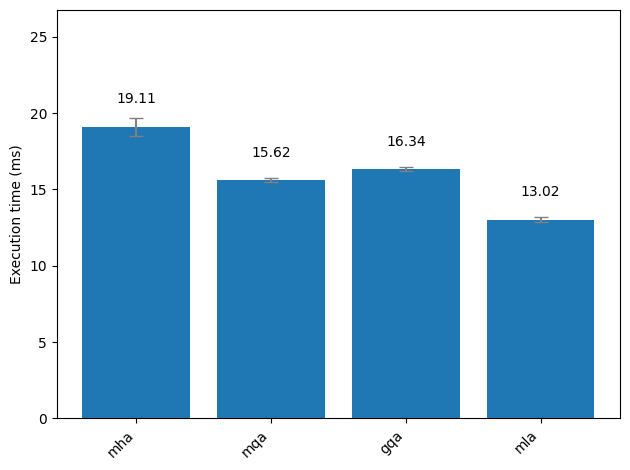

In [27]:
plot_execution_times(attention_fns, execution_means, execution_stds)